In [1]:
#DATA SIMULATION 
import pandas as pd
import numpy as np

# Parameters
n_orders = 1000
n_products = 50
n_routes = 10

# Simulate data
np.random.seed(42)  # For reproducibility

# Create columns
order_ids = np.arange(1, n_orders + 1)
product_ids = np.random.randint(1, n_products + 1, size=n_orders)
inventory_levels = np.random.randint(100, 1000, size=n_orders)  # Inventory levels
delivery_routes = np.random.choice(['Route_A', 'Route_B', 'Route_C', 'Route_D'], size=n_orders)
delivery_times = np.random.uniform(1, 12, size=n_orders)  # Hours to deliver
cost_per_delivery = np.random.uniform(50, 500, size=n_orders)  # Delivery costs
demand_forecast = np.random.randint(50, 1000, size=n_orders)
actual_sales = demand_forecast * np.random.uniform(0.8, 1.2, size=n_orders)  # Simulating actual sales close to forecast

# Create DataFrame
supply_chain_data = pd.DataFrame({
    'order_id': order_ids,
    'product_id': product_ids,
    'inventory_level': inventory_levels,
    'delivery_route': delivery_routes,
    'delivery_time': delivery_times,
    'cost_per_delivery': cost_per_delivery,
    'demand_forecast': demand_forecast,
    'actual_sales': actual_sales
})

# Show first few rows
print(supply_chain_data.head())


   order_id  product_id  inventory_level delivery_route  delivery_time  \
0         1          39              476        Route_B       1.121344   
1         2          29              388        Route_B       5.577694   
2         3          15              536        Route_D       6.294786   
3         4          43              761        Route_C       1.211115   
4         5           8              376        Route_C       3.857945   

   cost_per_delivery  demand_forecast  actual_sales  
0         113.361327              513    454.500872  
1         330.086139              162    132.319272  
2         401.594835              320    302.546606  
3         310.234280              212    177.960791  
4         116.133219              509    430.914890  


In [2]:
supply_chain_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_id           1000 non-null   int64  
 1   product_id         1000 non-null   int32  
 2   inventory_level    1000 non-null   int32  
 3   delivery_route     1000 non-null   object 
 4   delivery_time      1000 non-null   float64
 5   cost_per_delivery  1000 non-null   float64
 6   demand_forecast    1000 non-null   int32  
 7   actual_sales       1000 non-null   float64
dtypes: float64(3), int32(3), int64(1), object(1)
memory usage: 50.9+ KB


In [5]:
#EDA WE FIRST CHECK FOR MISSING VALUES, DUPLICATES ETC
#checking for missing values
supply_chain_data.isna().any(axis=1).sum()

np.int64(0)

In [8]:
#check for and drop any duplicates
supply_chain_data.duplicated().any().sum()

np.int64(0)

In [9]:
#Descriptive Statistics
supply_chain_data.describe()

,order_id,product_id,inventory_level,delivery_time,cost_per_delivery,demand_forecast,actual_sales
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,25.830000,542.508000,6.465661,274.899006,541.83500,538.751650
std,288.819436,14.346809,263.685931,3.172583,129.766628,276.34013,281.337065
min,1.000000,1.000000,100.000000,1.001482,50.005236,53.00000,44.478225
25%,250.750000,14.000000,321.000000,3.856630,161.377208,298.75000,300.293562
50%,500.500000,26.000000,537.500000,6.462361,276.296836,541.00000,537.319787
75%,750.250000,37.000000,771.250000,9.235596,387.676281,786.25000,769.979822
max,1000.000000,50.000000,998.000000,11.981823,499.800966,999.00000,1167.215829


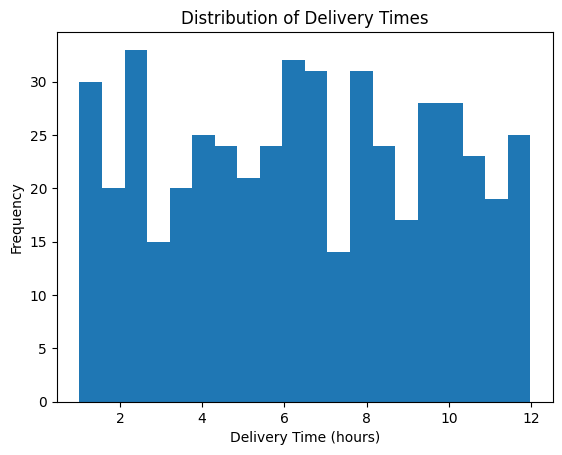

In [10]:
#FEATURE ENGINEERING

# Create new feature: delivery delay
supply_chain_data['delivery_delay'] = supply_chain_data['delivery_time'] - supply_chain_data['delivery_time'].mean()

# Create new feature: demand_gap (difference between forecast and actual sales)
supply_chain_data['demand_gap'] = supply_chain_data['actual_sales'] - supply_chain_data['demand_forecast']

# Filter out negative values
supply_chain_data = supply_chain_data[supply_chain_data['demand_gap'] >= 0]

# Visualize the data (delivery time distribution)
import matplotlib.pyplot as plt

plt.hist(supply_chain_data['delivery_time'], bins=20)
plt.title('Distribution of Delivery Times')
plt.xlabel('Delivery Time (hours)')
plt.ylabel('Frequency')
plt.show()
